# Optimizing workflows
In this notebook we demonstrate how to setup a workflow and optimize its parameters with a given sparse annotation.

See also:
* [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
* [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

In [1]:
from skimage.io import imread
from scipy.optimize import minimize
import numpy as np
import pyclesperanto_prototype as cle

We start with loading an example image and a manual annotation. Not all objects must be annotated (sparse annotation).

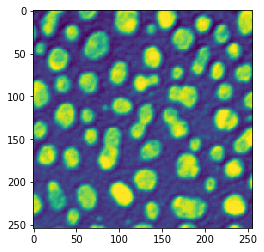

In [2]:
blobs = cle.push(imread('../../data/blobs.tif'))

cle.imshow(blobs)

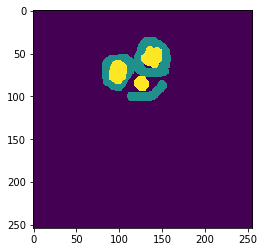

In [3]:
annotation = cle.push(imread('../../data/blobs_annotated.tif'))

cle.imshow(annotation)

Next, we define an image processing workflow that results in a binary image.

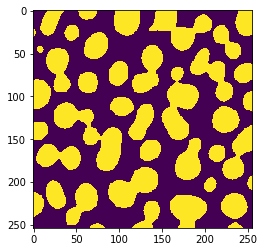

In [4]:
def workflow(image, sigma, threshold):
    blurred = cle.gaussian_blur(image, sigma_x=sigma, sigma_y=sigma)
    binary = cle.greater_constant(blurred, constant=threshold)
    return binary
  
# Test the workflow with more or less random parameters
test = workflow(blobs, 5, 100)
cle.imshow(test)

Our [fitness function](https://en.wikipedia.org/wiki/Fitness_function) takes two parameters: A given segmentation result (test) and a reference annotation. It then determines how good the segmentation is, e.g. using the Jaccard index.

In [5]:
binary_and = cle.binary_and

def fitness(test, reference):
    """
    Determine how correct a given test segmentation is. 
    As metric we use the Jaccard index.
    Assumtion: test is a binary image(0=False and 1=True) and 
    reference is an image with 0=unknown, 1=False, 2=True.
    """
    negative_reference = reference == 1
    positive_reference = reference == 2
    negative_test = test == 0
    positive_test = test == 1
    
    # true positive: test = 1, ref = 2
    tp = binary_and(positive_reference, positive_test).sum()
    
    # true negative: 
    tn = binary_and(negative_reference, negative_test).sum()
    
    # false positive
    fp = binary_and(negative_reference, positive_test).sum()

    # false negative
    fn = binary_and(positive_reference, negative_test).sum()
    
    # return Jaccard Index
    return tp / (tp + fn + fp)

fitness(test, annotation)

0.74251497

In [6]:
# test a couple of thresholds and print corresponding fitness
for t in range(70, 180, 10):
    test = workflow(blobs, 5, t)
    print(fitness(test, annotation))

0.49048626
0.5843038
0.67019403
0.74251497
0.8183873
0.8378158
0.79089373
0.7024014
0.60603446
0.49827588
0.3974138


The `fun`ction takes only numerical parameters that should be optimized.

Optimization terminated successfully.
         Current function value: -0.857613
         Iterations: 22
         Function evaluations: 65
 final_simplex: (array([[  3.89501953, 121.94091797],
       [  3.89498663, 121.9409585 ],
       [  3.89500463, 121.9403702 ]]), array([-0.85761315, -0.85761315, -0.85761315]))
           fun: -0.8576131463050842
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 22
        status: 0
       success: True
             x: array([  3.89501953, 121.94091797])


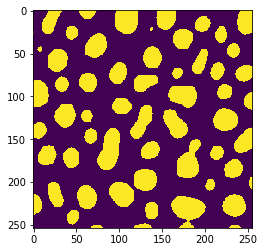

In [7]:
def fun(x):
    # apply current parameter setting
    test = workflow(blobs, x[0], x[1])
    # as we are minimizing, we multiply fitness with -1
    return -fitness(test, annotation)

# starting point in parameter space
x0 = np.array([5, 100])

# run the optimization
res = minimize(fun, x0, method='nelder-mead', options={'xatol': 1e-3, 'disp': True})

# print and show result
print(res)

x = res['x']
best_binary = workflow(blobs, x[0], x[1])
cle.imshow(best_binary)